Used this script to create a starting point for ground truth labels of the lipid droplets

In [5]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
import skimage as sk
import napari
import pandas as pd
import os
from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

from bioio import BioImage
import napari

Read in czi files with bioio package, need to run np.squeeze to remove empty dims from czi format

In [2]:
files = sorted(glob('E:/Lien_Lab/Sam/OIC-90_Lipid_Droplet_Cont/AiryScan_20250813/*.czi'))
files_bioio = list(map(BioImage,files))

In [3]:
imgs_data = [img.data for img in files_bioio]
imgs = [np.squeeze(img) for img in imgs_data]

In [4]:
test_img = imgs[1]
viewer = napari.view_image(test_img)

3533987585.py (2): `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.


In [6]:
test_img.shape

(3, 34, 1012, 1012)

In [8]:
#select ch2 for stardist prediction of lipids
ch2 = [img[1,...] for img in imgs]

selected model is from training on confocal images, not airyscan, using to get a starting set of labels to work off of

In [10]:
model = StarDist3D(None,name='stardist',basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.634007, nms_thresh=0.5.


In [14]:
all_labels = []
for i in range(len(ch2)):
    n_channel = 1 if ch2[i].ndim == 3 else ch2[i].shape[-1]
    axis_norm = (0,1,2)   # normalize channels independently
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    img = normalize(ch2[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img, n_tiles=model._guess_n_tiles(img), show_tile_progress=False)
    all_labels.append(labels)
    #save_tiff_imagej_compatible(path+names[i][:-4]+"_labels.tif", labels, axes='ZYX')
    print(str(i)+" of "+str(len(imgs))+" complete")

functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, None, None, None, 1))


0 of 15 complete
1 of 15 complete
2 of 15 complete
3 of 15 complete
4 of 15 complete
5 of 15 complete
6 of 15 complete
7 of 15 complete
8 of 15 complete
9 of 15 complete
10 of 15 complete
11 of 15 complete
12 of 15 complete
13 of 15 complete
14 of 15 complete


Looked at the labels with Napari, saw that there are many false detections of dim signal. Used filtering with `sk.measure.regionprops` to remove objects with dimmer intensity values.

In [90]:
voxel = [0.5,0.13,0.13]
test_img = ch2[0]
test_mask = all_labels[0]
viewer = napari.view_image(test_img,scale=voxel)
viewer.add_labels(test_mask,scale=voxel)

2205584405.py (4): `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.


<Labels layer 'test_mask' at 0x2ba1dbf55b0>

In [91]:
#clean up labels to keep brighter spots
props = sk.measure.regionprops_table(test_mask,test_img,properties=('label','intensity_mean'))
df = pd.DataFrame.from_dict(props)

Plotting histogram of the intensity_mean of each object to find a potential threshold for removing dimmer detections.

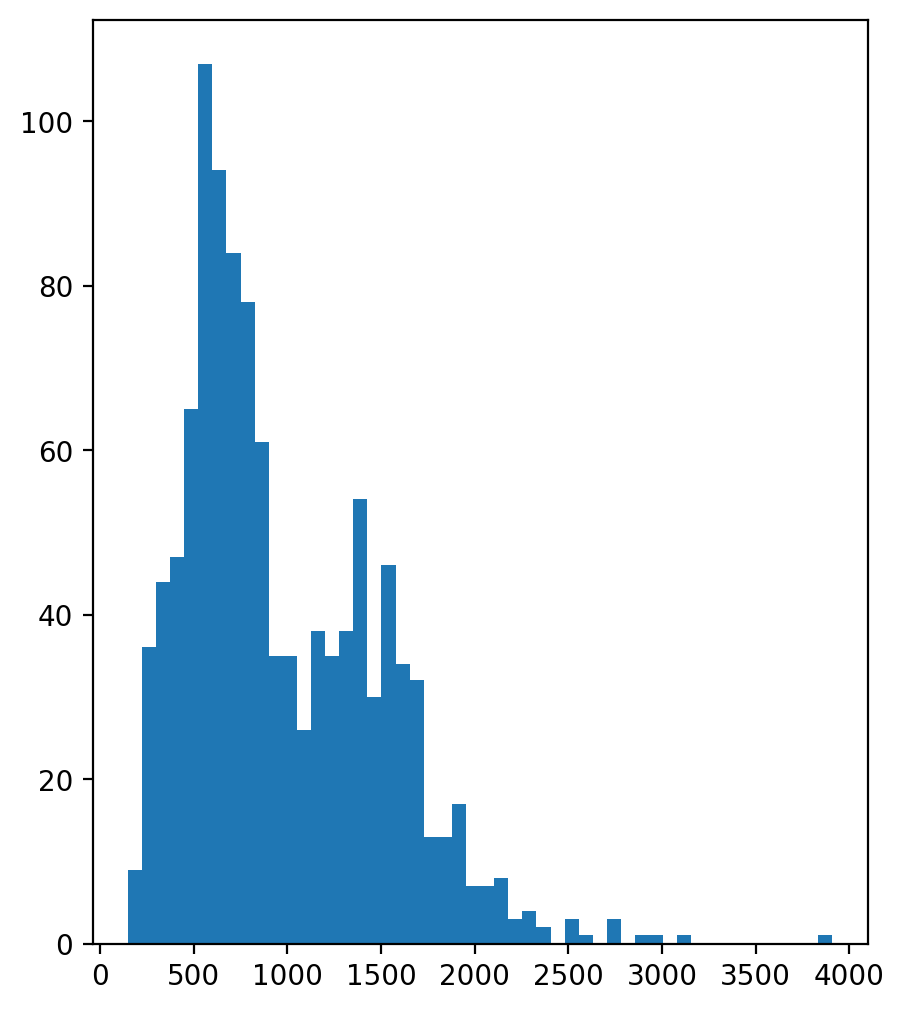

In [92]:
fig = plt.figure(figsize=(5,6))
plt.hist(x=df['intensity_mean'],bins=50)
plt.show()

Set up loop to filter dim objects and save Ch2 and final masks as tiffs.

In [106]:
img_save_loc = "../Tiffs/"
mask_save_loc = "../Masks/"
for i in range(len(ch2)):
    img = ch2[i]
    mask = all_labels[i]
    save_tiff_imagej_compatible(os.path.join(img_save_loc,"img_0"+str(i)+'.tiff'),img, axes='ZYX')
    reg_props = sk.measure.regionprops(mask,img)
    labels_to_remove = []
    for prop in reg_props:
        if not (prop.intensity_mean > 1000):
            labels_to_remove.append(prop.label)
    mask[np.isin(mask,labels_to_remove)] = 0
    save_tiff_imagej_compatible(os.path.join(mask_save_loc,'mask_0'+str(i)+'.tiff'),mask, axes='ZYX')

__init__.py (43): Converting data type from 'int32' to ImageJ-compatible 'int16'.
